# Understanding timestamping in  ASKAP

So this is a painful and possibly contraversial topic, but here goes.

There are two timestamps flying around ASKAP:
- Binary Atomic Time (BAT) - this is the number of microseconds since MJD=0 (i.e. MJD=JD - 2400000.5) in the atomic reference frame (i.e. no leap seconds). This timestamp is not does not strictly align with askap sample times becuase ...

- Frame ID (FID) is the number of "samples" since the system was reset. The number of samples is at rate of the course filterbank which is 1 MHz but oversampled by 32/27, i.e. the coarse filterbank period is 1us * 27/32. If you're samples are after the fine filterbank (which CRACO is) then further reduced by a factor of 64 from the fine filterbank. I.e. the "frame ID" period is 1us * 27/32 * 64

When the sytem is "Synced" (e.g. an operator presses the "Sync Reset") button in the GUI, the software tells everything to start at a particular BAT a few seconds in the future. When everything starts, the frame ID is set to zero and off it goes. Frame IDs are generally passed around with the data - the first part where frame IDs are assigned to data is at the digital reciever, after the samples are channelised.

Worse, the hardware doesn't actually pass around enough bits of BAT to unambiguously know the time - you have to work it out from the context, by which I mean, roughly what day it is.

Also FYI: The ASKAP correlator and beamformer operate on "banks" of 2048 fine filterbank samples, which is equivalent ot 110 milliseconds.

So, with that hopeless introduction out of the way, let's look at some data.


In [1]:
coarse_sample_rate = 1e6 * 32 / 27
coarse_sample_rate

1185185.1851851852

In [2]:
coarse_period = 1/coarse_sample_rate
coarse_period

8.4375e-07

In [3]:
fine_sample_rate = coarse_sample_rate / 64
fine_sample_rate

18518.51851851852

In [4]:
fine_period = 1/ fine_sample_rate
fine_period

5.4e-05

In [5]:
bank_time = fine_period *2048
bank_time

0.110592

In [6]:
# Just so I can claim you've seen how aweful these number look - for your viewing pleasure: 
32/27

1.1851851851851851

In [7]:
27/32

0.84375

In [8]:
import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits

%matplotlib notebook

In [9]:
p = CardcapFile('data/SB41378/vela_a112_k16_spi32_ps_b0_b07_c01+f6.fits')

In [10]:
# lets look at the header
p.mainhdr

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3752 / length of dimension 1                          
NAXIS2  =                12800 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
TTYPE1  = 'frame_id'                                                            
TFORM1  = 'K       '                                                            
TZERO1  =                    0                                                  
TTYPE2  = 'bat     '                                                            
TFORM2  = 'K       '        

The following code is useful in understanding the header

```
        now = Time.now()
        now.format = 'fits'
        dtaiutc = leapseconds.dTAI_UTC_from_utc(now.to_datetime()).seconds
        dtaiutc2 = (now.tai.datetime - now.datetime).seconds

        hdr['NOWMJD'] = (now.mjd, 'UTC MJD at file creation time')
        hdr['NOWJD'] = (now.jd, 'UTC JD at file creation time')
        hdr['NOWTAI'] = (str(now.tai), 'TAI string at file creation time')
        hdr['NOWSTR'] = (str(now), 'UTC string at file creation time')
        hdr['NOWUNIX'] = (now.unix, 'Now in UNIX time')
        hdr['NOWUTAI'] = (now.unix_tai, 'Now in UNIX TAI')
        hdr['DTAIUTC'] = (dtaiutc, 'TAI-UTC at file creation time from leapseconds.py')
        hdr['DTAIUTC2'] = (dtaiutc2, 'TAI-UTC at file creation time from astropy')
        ```
        

In [11]:
from astropy.time import Time

So the first thing to notice is "SYNCBAT" - this is the BAT when the system was reset - i.e. FRAME_ID was zero - it's traditional to store this as hexadecimal, but we can parse it into an int

In [12]:
syncbat_str = p.mainhdr['SYNCBAT']
print(f'Header is={syncbat_str} And the parsed version  as a hex string should be equal:0x{p.syncbat:x}')

Header is=0x12562af83fe4be And the parsed version  as a hex string should be equal:0x12562af83fe4be


In [13]:
# OK, so what does this look like as a time - note MJD is in days and we have to say TAI "
t = Time(p.syncbat/1e6/3600/24, format='mjd', scale='tai')
t

<Time object: scale='tai' format='mjd' value=59737.17748083183>

In [14]:
# yes, but actualy as a human-readable time
t.iso

'2022-06-07 04:15:34.344'

OK - so that looks reasonable I guess -we get syncbat from the software part of the system, and that fills in the higher few bits of BAT. WE'll see that isn't all passed around - but we'll get to that. Let's look at when the file was created:

In [15]:
p.mainhdr['NOWSTR']

'2022-06-07T04:19:06.273'

aaah, but don't forget NOW is UTC but NOWTAI is atomic time - and they'r edifferent - by like 37 seconds (this week)


In [16]:
p.mainhdr['NOWTAI']

'2022-06-07T04:19:43.273'

In [17]:
# and I even record the DELTA TAI - UTC offset from 2 different packages, just to see if they agree
p.mainhdr['DTAIUTC']

37

In [18]:
p.mainhdr['DTAIUTC2']

37

So we can se that the system was synched a few minutes before the file was created. That makes sense as we started up the system and synched it up and got straight into the juicy goodness of capturing data.

Next lets look at the first packet in the data stream. The packets had the debug headers included when we started recording, which means we included FRAMEID and BAT for each packet. If we don't include debug headers, we can also get the frame ID for the first integration from the RoCE Immediate data, but we wont' worry about that for now.

Frame ID is the frame ID the data in each packet, but the BAT is just that BAT of when the packet was created. It's roughly right, but not exactly. Let's take a look:

In [19]:
pkts = p.load_packets()

<IPython.core.display.Javascript object>


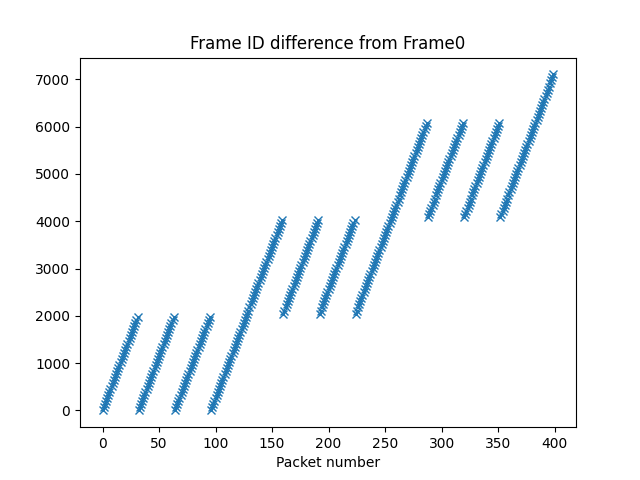

Text(0.5, 1.0, 'Frame ID difference from Frame0')

In [20]:
figure()
fid0 = pkts['frame_id'][0]
plot(pkts['frame_id'][0:400] - fid0, 'x')
xlabel('Packet number')
title('Frame ID difference from Frame0')

This data file only has beam 0 in it. Notice 
- frame ID Goes up in steps of 32. This is becuase frame ID is the first sample of every integration, and we're integrating 32 samples per integration.
- The frame ID goes up to a value of (2048 - 32) before repeating. This is because CRACO processes 2048 samples in every block. As we're integrating 32 samples per block, we get a total of 64 integrations per frame.
- The frame IDs repeat 4 times, before continuuing - this is because each FPGA processes 4 channels, one after the other.

In [21]:
# By the way , how do we know how many samples per integration there are?
p.mainhdr['SAMPINT']

32

By contrast, we shouldn't really trust the BAT in the debug headers, as it's just the BAT when the packet was created - which is many moons after the sample was recorded


<IPython.core.display.Javascript object>


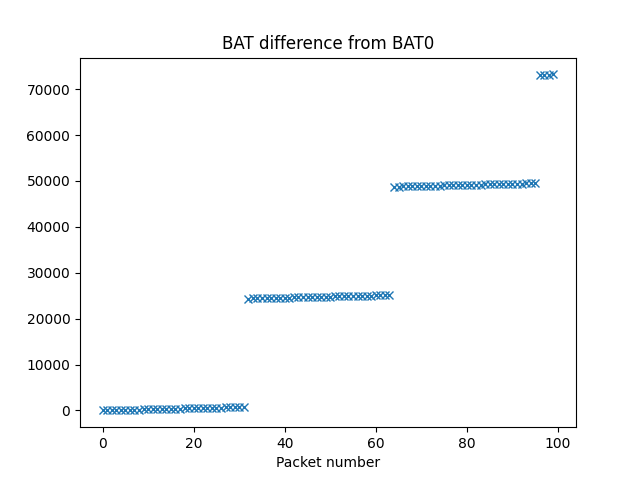

Text(0.5, 1.0, 'BAT difference from BAT0')

In [22]:
figure()
bat0 = pkts['bat'][0]
plot(pkts['bat'][0:100] - bat0, 'x')
xlabel('Packet number')
title('BAT difference from BAT0')

Notice:
- BAT increases a little bit for each integration, and jumps at the end of every frame because, I don't know, it finished processing early and had a little rest before more data arrived.
- We shouldn't use this BAT to work out the timestamp for the integration - but it's a useful check for latency

OK, now, after all these warnings about BAT - let's have some fun with frame numbers and the sync bat. Let's look at the first frame in the series

In [23]:
fid0

4735008

The BAT of this frame ID should be equal to. Recall each frame ID is 1us * 27/32 (oversampling) * 64 (fine filterbank)

In [24]:
fid0_bat = int(p.syncbat + fid0*27*64//32)
fid0_bat

5161292390034302

In [25]:
# We can make this into a real timestamp for our amusement
fid0_bat_t = Time(fid0_bat / 1e6 / 3600 / 24, format='mjd', scale='tai')
fid0_bat_t.iso

'2022-06-07 04:19:50.034'

In [26]:
# recall the file was created at
p.mainhdr['NOWTAI']

'2022-06-07T04:19:43.273'

So the first integration was recored about 7 seconds after the file was created. This makes sense as it takes time to start the CRACO capture

In [27]:
# OK so now let's look at the bat corresponding bat that was recorded in the packet
bat0

184809373732

Well gee, that number isn't very similar to the one in the file  - now why is that???? Well, let's look at them in hex


In [28]:
hex(bat0)

'0x2b077f4024'

In [29]:
hex(fid0_bat)

'0x12562b077d6b7e'

So you can see that BAT *recorded* for that integration and BAT we *calculated* from the frame ID + syncbat are pretty similar (see the first byte of bat0 is 0x2b - or not to be?), but the recorded one is only 40 bits long, whereas the proper bat is 56 bits long. i.e. the recorded bat is missing the top 16 bits. So let's OR them in - assuming syncbat was the correct  time (some additional logic required here if it's wrapped)

In [30]:
bat0_full = int(bat0) | (0xffff0000000000 & p.syncbat)
hex(bat0_full)

'0x12562b077f4024'

In [31]:
# OK so now we see the recorded bat after adding in the top bits, is looking a lot like the bat we calculated.
# For amusement, let's work out how long after teh sample was recorded way up in the digitiser, the packet was actually sent

latency = bat0_full - fid0_bat
latency # microseconds

119974

So the latency was about 120 milliseconds. This is understabable as the ASKAP Correlator and beamformer operate on frames of 2048 fine filterbank samples, which is about 110 milliseconds.

Note, this functionality is also implemented in the file

In [32]:
p.mjd0

<Time object: scale='tai' format='mjd' value=59737.18044021182>

In [33]:
p.mjd0.iso

'2022-06-07 04:19:50.034'